# Extracting data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
xr.set_options(display_style='text')

In [2]:
import sys
sys.path.append('/home/voehring/voehring/notebooks/spatial-data')
import spatial_data

In [3]:
ds = xr.load_dataset('../../../small_image.zarr')

/home/voehring/.local/lib/python3.8/site-packages/xarray/backends/plugins.py:117: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


## Extracting information

Once the image and segmentation masks are loaded in the `xarray` object we can leverage the `se.quantify()` accessor to capture the expression of each cells across the image channels (see also the Importing and saving data tutorial).

In [4]:
ds

<xarray.Dataset>
Dimensions:        (channels: 5, y: 500, x: 500, labels: 12, props: 2,
                    cells: 3380, features: 4)
Coordinates:
  * cells          (cells) int64 12 77 91 158 ... 218634 218740 218775 218790
  * channels       (channels) <U7 'Hoechst' 'CD4' 'CD8' 'FOXP3' 'BCL6'
  * features       (features) <U16 '_labels' '_original_labels' '_x' '_y'
  * labels         (labels) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * props          (props) <U6 '_color' '_name'
  * x              (x) int64 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
  * y              (y) int64 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
Data variables:
    _image         (channels, y, x) uint16 10816 12359 14504 ... 129 149 59
    _labels        (labels, props) object '#008080' ... 'Cell type 12'
    _obs           (cells, features) float64 5.0 4.0 49.25 ... 7.0 73.59 491.4
    _segmentation  (y, x) int32 63194 63194 63194 63194 ... 59633 59633 59633

The `se.quantify()` accessor returns an `xarray` with the coordinates `cells` and `channels`. By default it will sum the intensity over the region of each cell.

In [5]:
da = ds.se.quantify()
da

<xarray.DataArray (cells: 3380, channels: 5)>
array([[689660.,  79104., 507216.,  11554.,  22356.],
       [547400., 111992.,   8004.,   6061.,  18178.],
       [776478., 113204.,  35664.,   9373.,  18032.],
       ...,
       [375836.,  45599.,  13118.,   3591.,  11830.],
       [181330.,  49300.,  11161.,   2535.,   7177.],
       [142990.,  11275.,   3666.,   1303.,   5227.]])
Coordinates:
  * cells     (cells) int64 12 77 91 158 243 ... 218634 218740 218775 218790
  * channels  (channels) <U7 'Hoechst' 'CD4' 'CD8' 'FOXP3' 'BCL6'

It is easy to write custom functions for `se.quantify`. These must accept two arguments `regionmask` and `intensity_image` and return the value of interest. The following function calculates the log expression over the segemented cell(s).

In [6]:
def log_expression(regionmask, intensity_image):
    return np.log(np.sum(intensity_image[regionmask])+1)

In [7]:
ds.se.quantify(func=log_expression)

<xarray.DataArray (cells: 3380, channels: 5)>
array([[13.44395545, 11.27853136, 13.1366942 ,  9.35487352, 10.01489475],
       [13.2129369 , 11.62619165,  8.98782163,  8.70979506,  9.80802236],
       [13.56252488, 11.63695561, 10.48192509,  9.14569518,  9.79995869],
       ...,
       [12.83691082, 10.727663  ,  9.48181684,  8.18646443,  9.37847848],
       [12.10807937, 10.80569964,  9.32027043,  7.83834332,  8.87877607],
       [11.87053697,  9.33043185,  8.20712917,  7.17319174,  8.56178407]])
Coordinates:
  * cells     (cells) int64 12 77 91 158 243 ... 218634 218740 218775 218790
  * channels  (channels) <U7 'Hoechst' 'CD4' 'CD8' 'FOXP3' 'BCL6'

## Inspecting the expression of specific cells

In the following section we illustrate how to pull out the expression spectra of specific cells. We start by inspecting the region of interest by slicing the respective region and cell types using `.im[]` and `.la[]` accessor.

Dropped 2830 cells.


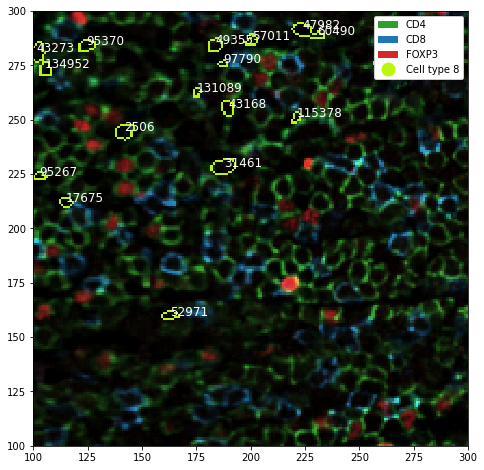

In [8]:
fig = plt.figure(figsize=(8, 8))
ax = plt.gca()

_ = (ds
     .im[['CD4', 'CD8', 'FOXP3'], 100:300, 100:300]
     .im.colorize(colors=['C2', 'C0', 'C3'])
     .la[8].la.render_label()
     .pl.imshow(legend_label=True, legend_background=True, ax=ax)
     .pl.annotate()
    )

To extract the expression spectra we simply subset the region and cells followed by `se.quantify()`.

In [9]:
da = ds.im[100:300, 100:300].la[8].se.quantify()

Dropped 2830 cells.


We obtain a `xarray` data array that contains the expression of our cell selection.

In [10]:
da

<xarray.DataArray (cells: 17, channels: 5)>
array([[4.31490e+05, 4.80420e+04, 7.53160e+04, 2.23300e+03, 1.55520e+04],
       [1.02598e+05, 3.44300e+03, 2.42630e+04, 5.52000e+02, 4.76800e+03],
       [7.13390e+05, 5.50030e+04, 7.77500e+03, 1.10510e+04, 2.29680e+04],
       [3.11829e+05, 5.49320e+04, 1.00680e+04, 3.73800e+03, 1.46140e+04],
       [3.69859e+05, 5.64970e+04, 3.63500e+03, 4.17100e+03, 1.10010e+04],
       [1.88742e+05, 2.44370e+04, 4.44800e+03, 2.89600e+03, 1.02780e+04],
       [3.82525e+05, 4.50230e+04, 9.93000e+02, 6.20500e+03, 1.34300e+04],
       [2.83051e+05, 8.23600e+03, 1.47000e+03, 2.16700e+03, 8.98600e+03],
       [1.30254e+05, 3.59710e+04, 1.22340e+04, 1.77800e+03, 6.86100e+03],
       [2.19349e+05, 4.32470e+04, 1.30200e+04, 2.99800e+03, 8.53500e+03],
       [1.19460e+05, 2.00290e+04, 7.03100e+03, 9.01000e+02, 4.64100e+03],
       [9.33400e+04, 3.29720e+04, 2.36810e+04, 1.87900e+03, 1.17750e+04],
       [6.30890e+04, 9.39200e+03, 1.07980e+04, 8.34000e+02, 3.56200e+03],
       [2.75438e+05, 8.96650e+04, 1.26560e+04, 3.02200e+03, 6.95600e+03],
       [1.80743e+05, 4.16640e+04, 1.81640e+04, 1.38100e+03, 7.59800e+03],
       [5.84840e+04, 2.36250e+04, 5.04310e+04, 1.55100e+03, 3.81100e+03],
       [1.90441e+05, 3.12430e+04, 6.47920e+04, 2.82200e+03, 7.09300e+03]])
Coordinates:
  * cells     (cells) int64 2506 17675 31461 43168 ... 115378 131089 134952
  * channels  (channels) <U7 'Hoechst' 'CD4' 'CD8' 'FOXP3' 'BCL6'

To pull out the expression of a specific cell, say cell 52971, we can retrieve it as follows.

In [12]:
da.loc[52971]

<xarray.DataArray (channels: 5)>
array([283051.,   8236.,   1470.,   2167.,   8986.])
Coordinates:
    cells     int64 52971
  * channels  (channels) <U7 'Hoechst' 'CD4' 'CD8' 'FOXP3' 'BCL6'

To understand the output better we may want to plot the data.

/tmp/ipykernel_1065/136886745.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(da.coords['channels'].values.tolist())


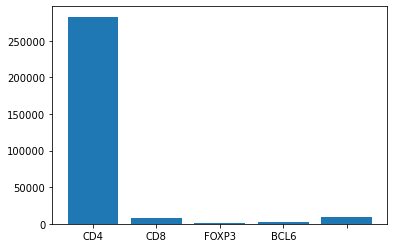

In [16]:
fig, ax = plt.subplots()
ax.bar(np.arange(5), da.loc[52971].values)
_ = ax.set_xticklabels(da.coords['channels'].values.tolist())

In [17]:
da.coords['channels'].values.tolist()

['Hoechst', 'CD4', 'CD8', 'FOXP3', 'BCL6']